# Project 4 - Lane Finding (part 2)

## Set up

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

In [7]:
!ls

README.md                     notebook.ipynb
camera_cal                    output_images
camera_cal_output             project_video.mp4
challenge_video.mp4           project_video_output copy.mp4
example_writeup.pdf           project_video_output.mp4
examples                      test_images
harder_challenge_video.mp4    writeup_template.md


Add images from the video to the test images

In [8]:
def extract_img(input_fname, t, output_folder):
    clip = VideoFileClip(input_fname)
    img = clip.get_frame(t)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_folder+"/"+input_fname.split(".")[0]+str(t)+"s.jpg", img)

In [9]:
extract_img("project_video.mp4", 22, "test_images")
extract_img("project_video.mp4", 40, "test_images")
extract_img("project_video.mp4", 41.7, "test_images")

## Camera calibration   
In this section we proceed to the camera calibration based on the chessboards

In [10]:
# prepare object points
nx, ny = 9, 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/ca**.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        write_name = 'camera_cal_output/'+fname.split("/")[1]
        cv2.imwrite(write_name, img)

Calibrate once

In [11]:
img = cv2.imread('camera_cal/calibration20.jpg')
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

Function to undistort

In [12]:
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

Test

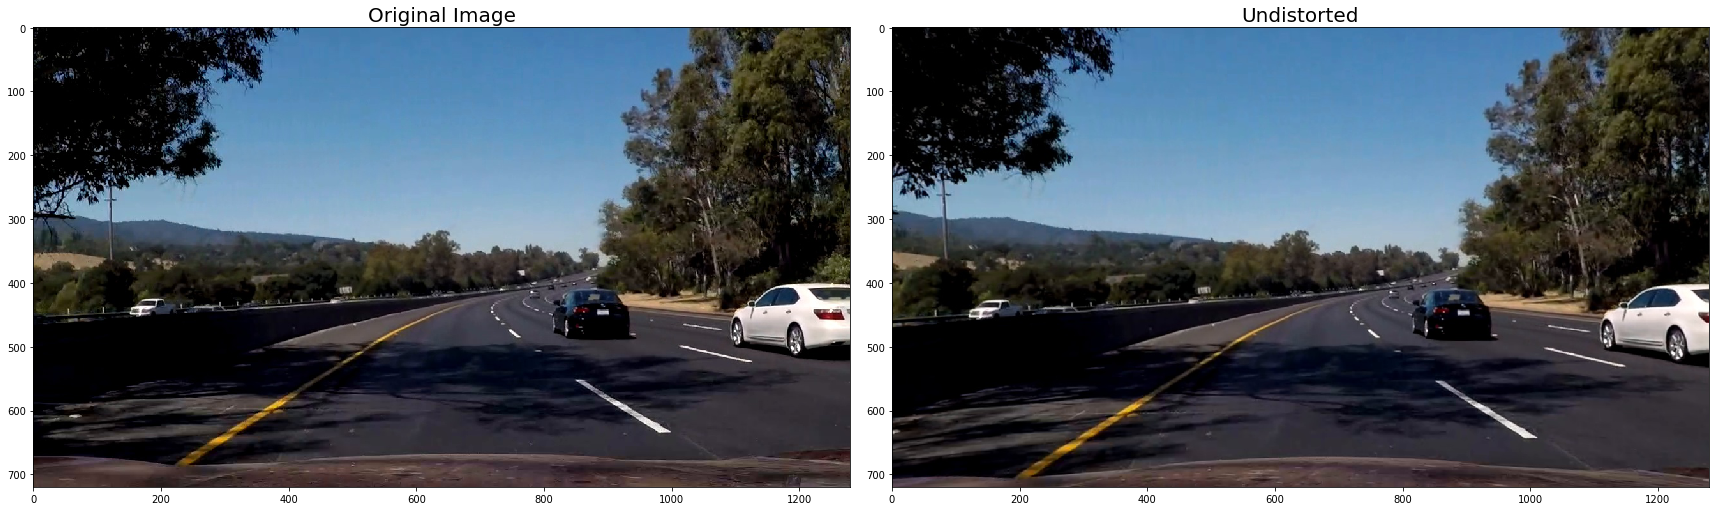

In [13]:
#img = cv2.imread('test_images/test5.jpg')
img = cv2.imread('test_images/project_video41.7s.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undist = undistort(img)

# Test undistortion on an image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)

ax2.imshow(undist)
ax2.set_title('Undistorted', fontsize=20)

## Binary image

In this section, we define the function which will define the binary image used to find lanes

In [14]:
def dual_binary(img, c_thresh=(200, 250), sobel_kernel=3, \
                sx_thresh=(30, 255), sy_thresh=(0, 255), mag_thresh = (30,255), ang_thresh = (np.pi/6, np.pi/2)):
    
    img = np.copy(img)
    
    # Convert to HSV color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    s_channel = hls[:,:,2]
    c_channel = (255-h_channel)*1/2+s_channel*1/2
    # Threshold color channel
    c_binary = np.zeros_like(c_channel)
    c_binary[(c_channel >= c_thresh[0]) & (c_channel <= c_thresh[1])] = 1
    
    # Sobel calculations
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Threshold x gradient
    abs_sobel = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    gradx = np.zeros_like(scaled_sobel)
    gradx[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold y gradient
    abs_sobel = np.absolute(sobely)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grady = np.zeros_like(scaled_sobel)
    grady[(scaled_sobel >= sy_thresh[0]) & (scaled_sobel <= sy_thresh[1])] = 1
    
    # Magnitude threshold
    abs_sobel = np.sqrt(sobelx**2+sobely**2)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    # Angle threshold
    ang = np.arctan2(np.abs(sobely), np.abs(sobelx))
    ang_binary = np.zeros_like(ang)
    ang_binary[(ang >= ang_thresh[0]) & (ang <= ang_thresh[1])] = 1
    
    # Combining Sobel
    sobel_binary = np.zeros_like(ang)
    sobel_binary[(((gradx == 1) & (grady == 1)) & (mag_binary == 1) & (ang_binary == 1))]=1
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sobel_binary), sobel_binary, c_binary))
    return color_binary

In [15]:
def binary(img):
    return np.amax(img, axis = 2)

In [16]:
def vis(img, result, final):
    # Plot the result
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=20)

    ax2.imshow(result)
    ax2.set_title('Green = gradient, Blue = color', fontsize=20)
    
    ax3.imshow(final, cmap = "gray")
    ax3.set_title('Final binary', fontsize=20)

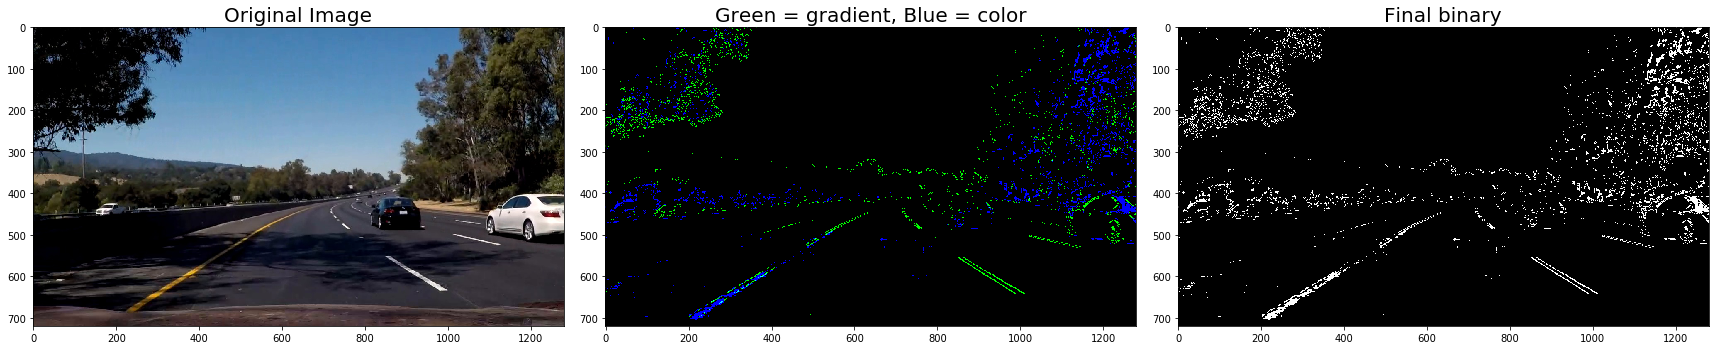

In [17]:
result = dual_binary(undist)
final = binary(result)
vis(img, result, final)

Check on all test images

In [18]:
def apply_save(input_folder, output_folder):
    images = glob.glob(input_folder+'/**.jpg')
    for fname in images:
        
        # Read and correct cv2 inversion
        img = cv2.imread(fname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Apply functions
        result = undistort(img)
        result = dual_binary(result)
        result = np.uint8(result*255)
        
        #Correct cv2 inversion and write
        result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
        write_name = output_folder+"/"+fname.split("/")[1]
        cv2.imwrite(write_name, result)

In [19]:
apply_save('test_images', 'output_images')

## Transform perspective

In [20]:
def transf_persp(img, inv = False):
    dy = img.shape[0]
    dx = img.shape[1]
    # bottom and top points
    #tx, ty = dx/2, dy/2
    mx, my = 600, 447
    bx, by = 200,dy
    #alpha = (my-ty)/(by-ty)
    #mx = alpha*bx + (1-alpha)*tx
    # Transformation
    src = np.float32([[bx,by],[mx,my],[dx-mx,my],[dx-bx,by]])
    dst = np.float32([[bx+100,by],[bx+100,0],[dx-bx-100,0],[dx-bx-100,by]])
    M = cv2.getPerspectiveTransform(src, dst)
    img_size = (img.shape[1],img.shape[0])
    if inv: warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR|cv2.WARP_INVERSE_MAP)
    if (not inv): warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

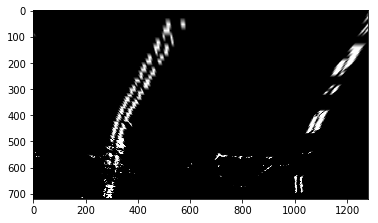

In [21]:
warped = transf_persp(final)
plt.imshow(warped, cmap = "gray")
plt.show()

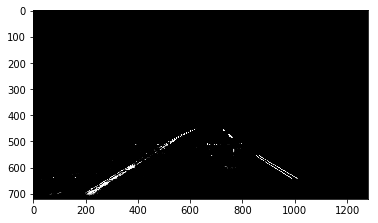

In [22]:
rewarped = transf_persp(warped, inv = True)
plt.imshow(rewarped, cmap = "gray")
plt.show()

## Lane search

In [31]:
def poly_fit(lefty, leftx, righty, rightx):
    # Class approach, not necessarily parallel
    #left = np.polyfit(lefty, leftx, 2)
    #right = np.polyfit(righty, rightx, 2)
    # Forcing the parallelism
    x = np.append(leftx, rightx-700)
    y = np.append(lefty, righty)
    central = np.polyfit(y, x, 2)
    left = np.polyfit(lefty, leftx - central[0]*(lefty**2) - central[1]*lefty, 2)
    right = np.polyfit(righty, rightx - central[0]*(righty**2) - central[1]*righty, 2)
    left[0:2] = right[0:2] = central[0:2]
    return left, right

In [36]:
def slide_search(binary_warped):
    
    global left_fit, right_fit
    
    histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img = np.uint8(out_img)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Set the width of the windows +/- margin
    margin = 75
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    if not np.array_equal(left_fit, np.array([])): # Lane already found in previous
        #print(left_fit)
        #print("use")
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin))
                          & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin))
                           & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))
    else: # Windows method
        #print(left_fit)
        #print("don't use")
        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set minimum number of pixels found to recenter window
        minpix = 50

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Update the search zone
    new_left, new_right = poly_fit(lefty, leftx, righty, rightx)
    if not np.array_equal(left_fit, np.array([])):
        left_fit = (4*left_fit+new_left)/5
        right_fit = (4*right_fit+new_right)/5
    else:
        left_fit = new_left
        right_fit = new_right
    
    return out_img, leftx, lefty, rightx, righty

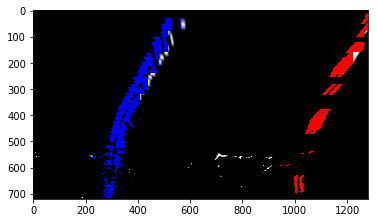

In [37]:
left_fit, right_fit = np.array([]), np.array([])
slide = slide_search(warped)[0]
slide = cv2.cvtColor(slide, cv2.COLOR_RGB2BGR)
plt.imshow(slide)
plt.show()

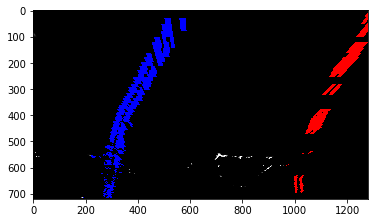

In [39]:
slide = slide_search(warped)[0]
slide = cv2.cvtColor(slide, cv2.COLOR_RGB2BGR)
plt.imshow(slide)

## Curvature search

In [40]:
def curvature(binary_warped, leftx, lefty, rightx, righty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    y_eval = binary_warped.shape[0]
    left_fit_cr, right_fit_cr = poly_fit(lefty*ym_per_pix, leftx*xm_per_pix, righty*ym_per_pix, rightx*xm_per_pix)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Text to write
    rad = "Curvature: {:.0f}(m)".format((left_curverad+right_curverad)/2)
    left = left_fit_cr[0]*(y_eval*ym_per_pix)**2 + left_fit_cr[1]*(y_eval*ym_per_pix) + left_fit_cr[2]
    right = right_fit_cr[0]*(y_eval*ym_per_pix)**2 + right_fit_cr[1]*(y_eval*ym_per_pix) + right_fit_cr[2]
    pos = (right+left)/2-binary_warped.shape[1]*xm_per_pix/2
    if pos>0: pos = "Position: {:.2f}(m) to the left".format(np.abs(pos))
    else: pos = "Position: {:.2f}(m) to the right".format(np.abs(pos))
    return rad, pos

In [41]:
slide = slide_search(warped)
curv = curvature(slide[0], slide[1], slide[2], slide[3], slide[4])
curv[0], curv[1]

('Curvature: 1402(m)', 'Position: 104.69(m) to the left')

## Drawing the green zone

In [42]:
def green_zone(warped):
    global left_fit, right_fit
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    #color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    color_warp = warp_zero
    # Creating the polynomial points
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    return color_warp

## Build the full pipeline for image/video

In [43]:
def full_process(img):
    img = undistort(img)
    lanes = dual_binary(img)
    lanes = binary(lanes)
    lanes = transf_persp(lanes)
    slide = slide_search(lanes)
    lanes = slide[0]
    curv = curvature(slide[0], slide[1], slide[2], slide[3], slide[4])
    green = green_zone(lanes)
    lanes = cv2.addWeighted(lanes, 1, green, 1, 0)
    lanes = transf_persp(lanes, inv = True)
    result = cv2.addWeighted(img, 1, lanes, 0.3, 0)
    cv2.putText(result,curv[0], (100,100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2)
    cv2.putText(result,curv[1], (100,200), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2)
    return result  

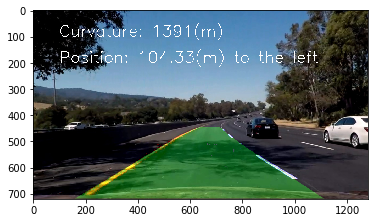

In [44]:
full = full_process(img)
plt.imshow(full)
plt.show()

In [ ]:
left_fit, right_fit = np.array([]), np.array([])
name_output = 'project_video_output.mp4'
clip = VideoFileClip("project_video.mp4")
output = clip.fl_image(full_process) #NOTE: this function expects color images!!
%time output.write_videofile(name_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


 10%|▉         | 124/1261 [01:28<14:09,  1.34it/s]

In [173]:
def convo_search(warped, window_width = 50, window_height = 80, margin = 80):

    def window_mask(width, height, img_ref, center,level):
        output = np.zeros_like(img_ref)
        output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
        return output

    def find_window_centroids(image, window_width, window_height, margin):

        window_centroids = [] # Store the (left,right) window centroid positions per level
        window = np.ones(window_width) # Create our window template that we will use for convolutions

        # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
        # and then np.convolve the vertical image slice with the window template 

        # Sum quarter bottom of image to get slice, could use a different ratio
        l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
        l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
        r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
        r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)

        # Add what we found for the first layer
        window_centroids.append((l_center,r_center))

        # Go through each layer looking for max pixel locations
        for level in range(1,(int)(warped.shape[0]/window_height)):
            # convolve the window into the vertical slice of the image
            image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
            conv_signal = np.convolve(window, image_layer)
            # Find the best left centroid by using past left center as a reference
            # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
            offset = window_width/2
            l_min_index = int(max(l_center+offset-margin,0))
            l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
            l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
            # Find the best right centroid by using past right center as a reference
            r_min_index = int(max(r_center+offset-margin,0))
            r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
            r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
            # Add what we found for that layer
            window_centroids.append((l_center,r_center))

        return window_centroids

    window_centroids = find_window_centroids(warped, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
    return output

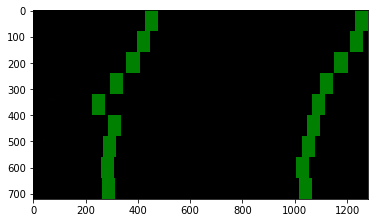

In [174]:
convo = convo_search(warped)
plt.imshow(convo)
plt.show()